In [1]:
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import drjit as dr 
from matplotlib import pyplot as plt
from PDE3D import PATH
from PDE3D.BoundaryShape import *
import numpy as np
import os

In [2]:
name = "motorbike-engine"
folder_name = os.path.join(PATH, "scenes", name)
xml_name = os.path.join(folder_name, "scene.xml")
sdf_data = np.load(os.path.join(folder_name, "sdf.npy"))
cam_res = [512, 512]
res_slice = [512, 512]
spp = 512
downsample = 1
sdf_data = sdf_data[::downsample,::downsample,::downsample]
cam_origin = mi.ScalarPoint3f([5,5,10])
scale_cam = 1/4
cam_target = mi.ScalarPoint3f(0)
cam_up = mi.ScalarPoint3f([0,1,0])


In [3]:
cam_sdf = mi.load_dict({
            "type": "orthographic",
            "to_world": mi.ScalarTransform4f().look_at(
                origin=cam_origin, target=cam_target, up=cam_up
            ).scale(1/scale_cam),
            'film_id': {
            'type': 'hdrfilm',
            'width': cam_res[0],
            'height': cam_res[1],
            'filter': { 'type': 'gaussian' }
    }
        })

cam_mesh = mi.load_dict({
            "type": "orthographic",
            "to_world": mi.ScalarTransform4f().look_at(
                origin=cam_origin, target=cam_target, up=cam_up
            ).scale(1/scale_cam),
            'film_id': {
            'type': 'hdrfilm',
            'width': cam_res[0],
            'height': cam_res[1],
            'filter': { 'type': 'gaussian' }
    }
        })

In [4]:
scene_mesh = mi.load_file(f"{PATH}/scenes/{name}/scene.xml")

In [5]:
print(scene_mesh.bbox())
max_range_mesh = dr.max(scene_mesh.bbox().max - scene_mesh.bbox().min) * 1.05
center_mesh = (scene_mesh.bbox().max + scene_mesh.bbox().min) / 2
print(max_range_mesh)
print(center_mesh)

BoundingBox3f[
  min = [-2.24631, -2.96587, -5.39982],
  max = [2.2273, 2.3492, 5.26982]
]
11.203123569488525
[-0.00950658, -0.308337, -0.0649974]


In [6]:
scene_sdf = mi.load_dict(
    {
        "type": "scene",
        "sdf": {
                "type" : "sdfgrid",
                "to_world" : mi.ScalarTransform4f().scale(max_range_mesh).translate(mi.ScalarPoint3f(-0.5 + center_mesh/max_range_mesh)),
                'grid': mi.TensorXf(sdf_data[...,np.newaxis])
                },
        "integrator": {"type": "path"},
        "light" : {"type" : "constant"}
    }
)
print(scene_sdf.bbox())
max_range_sdf = dr.max(scene_sdf.bbox().max - scene_sdf.bbox().min)
center_sdf = (scene_sdf.bbox().max + scene_sdf.bbox().min) / 2
print(max_range_sdf)
print(center_sdf)

BoundingBox3f[
  min = [-5.61107, -5.9099, -5.66656],
  max = [5.59205, 5.29322, 5.53656]
]
11.203123092651367
[-0.0095067, -0.308337, -0.0649977]


Text(0.5, 1.0, 'SDF')

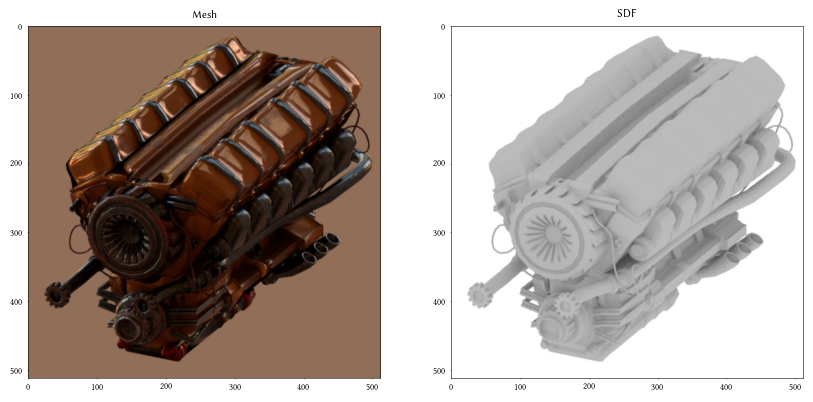

In [7]:
img1 = mi.render(scene_mesh, sensor = cam_mesh, spp = spp)
img2 = mi.render(scene_sdf, sensor = cam_sdf, spp = spp)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(mi.util.convert_to_bitmap(img1));
ax2.imshow(mi.util.convert_to_bitmap(img2));
ax1.set_title("Mesh")
ax2.set_title("SDF")